Importing numpy

In [1]:
import numpy as np

## First, add this file to your drive [File](https://drive.google.com/drive/folders/1T1ox5SBkEf5QDn1w07f2w2teXbpPOjQX?usp=sharing)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Then mount your drive using colab's icon in the files section to the left


In [3]:
features= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/labels.npy')

Making sure that the data has the correct length

In [4]:
assert len(features)==len(labels)

In [5]:
features.shape

(990, 128, 645)

In [6]:
features=features.reshape(990,1,128,645)
features.shape

(990, 1, 128, 645)

In [7]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

In [94]:
# from  sklearn.model_selection import train_test_split 
# x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.7, stratify=labels )

# transform =transforms.GaussianBlur(3 , (0.001,0.04))
# # changing them into torch format
# x_train = torch.tensor(x_train )
# x_test = torch.tensor(x_test)

# y_train =torch.tensor(y_train)
# y_test = torch.tensor(y_test)

# train = torch.utils.data.TensorDataset(x_train,y_train )
# test = torch.utils.data.TensorDataset(x_test,y_test)


# train_loader=torch.utils.data.DataLoader(train,batch_size=8,  
#                                          shuffle=True)
# test_loader=torch.utils.data.DataLoader(test,batch_size=8)

In [133]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        
    def __len__(self):
        return self.tensors[0].size(0)    

In [134]:
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.7, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.04))
# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=8)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=8)

In [140]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

GPU is enabled in this notebook.


In [141]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 16 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=32),
            nn.Dropout(0.4),
            nn.Linear(in_features=32, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

In [158]:
def train(model, device, train_loader, validation_loader, epochs , optimizer):
  criterion =  nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')
  return train_loss, train_acc, validation_loss, validation_acc

The Train accuracy= 0.24675324675324675 
 The Validation acc 0.38047138047138046
The Train loss= 3.480041027069092 
 The Validation loss 1.917810509079381


The Train accuracy= 0.6810966810966811 
 The Validation acc 0.4612794612794613
The Train loss= 0.9808358550071716 
 The Validation loss 1.7795683929794712


The Train accuracy= 0.8354978354978355 
 The Validation acc 0.5084175084175084
The Train loss= 0.501517653465271 
 The Validation loss 1.6829512401631004


The Train accuracy= 0.9494949494949495 
 The Validation acc 0.49158249158249157
The Train loss= 0.2411176562309265 
 The Validation loss 1.641997555368825


The Train accuracy= 0.9754689754689755 
 The Validation acc 0.4175084175084175
The Train loss= 0.13693822920322418 
 The Validation loss 2.061310871651298


The Train accuracy= 0.9725829725829725 
 The Validation acc 0.494949494949495
The Train loss= 0.12404270470142365 
 The Validation loss 1.6895029340919696


The Train accuracy= 0.976911976911977 
 The Validation acc 

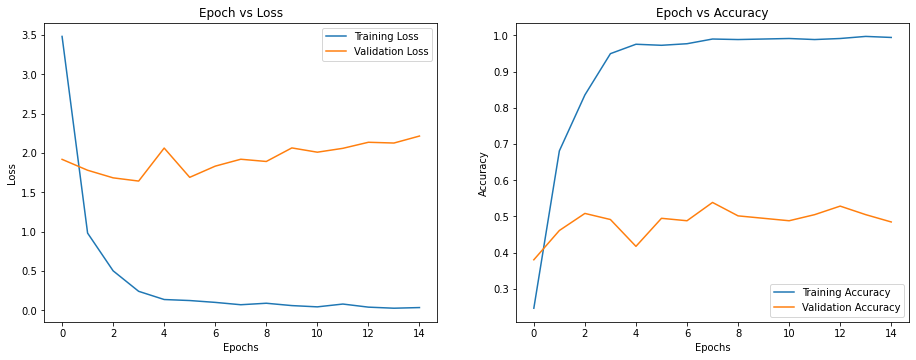

In [143]:
net = music_CNN().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader,test_loader, 15)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [154]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.2972582972582973 
 The Validation acc 0.4478114478114478
The Train loss= 2.9718003273010254 
 The Validation loss 1.5520684185780977


The Train accuracy= 0.6854256854256854 
 The Validation acc 0.569023569023569
The Train loss= 0.9942688941955566 
 The Validation loss 1.3176560135264146


The Train accuracy= 0.924963924963925 
 The Validation acc 0.5656565656565656
The Train loss= 0.3250406086444855 
 The Validation loss 1.3540249388468892


The Train accuracy= 0.9812409812409812 
 The Validation acc 0.569023569023569
The Train loss= 0.11355653405189514 
 The Validation loss 1.4496642696230035


The Train accuracy= 0.9913419913419913 
 The Validation acc 0.5892255892255892
The Train loss= 0.0658767819404602 
 The Validation loss 1.5084383236987235


The Train accuracy= 0.9942279942279942 
 The Validation acc 0.5791245791245792
The Train loss= 0.03276338055729866 
 The Validation loss 1.5316085772957242


The Train accuracy= 0.9927849927849928 
 The Validation acc

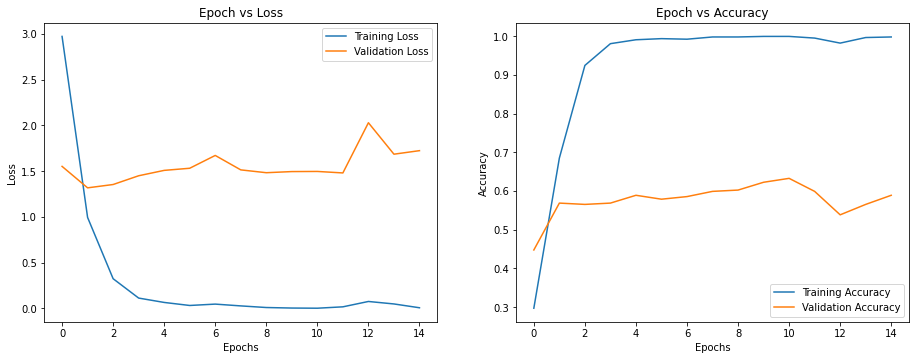

In [157]:
net = music_CNN().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader,test_loader, 15)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [166]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.17604617604617603 
 The Validation acc 0.27946127946127947
The Train loss= 2.607837200164795 
 The Validation loss 1.9664126069922196


The Train accuracy= 0.5165945165945166 
 The Validation acc 0.42424242424242425
The Train loss= 1.4193114042282104 
 The Validation loss 1.704551100730896


The Train accuracy= 0.70995670995671 
 The Validation acc 0.46464646464646464
The Train loss= 0.964124321937561 
 The Validation loss 1.5962951700938375


The Train accuracy= 0.810966810966811 
 The Validation acc 0.5185185185185185
The Train loss= 0.7236043214797974 
 The Validation loss 1.4433747780950446


The Train accuracy= 0.8715728715728716 
 The Validation acc 0.5286195286195287
The Train loss= 0.5202116966247559 
 The Validation loss 1.430661621062379


The Train accuracy= 0.9090909090909091 
 The Validation acc 0.5454545454545454
The Train loss= 0.4164521098136902 
 The Validation loss 1.3572639571992975


The Train accuracy= 0.9393939393939394 
 The Validation acc 0

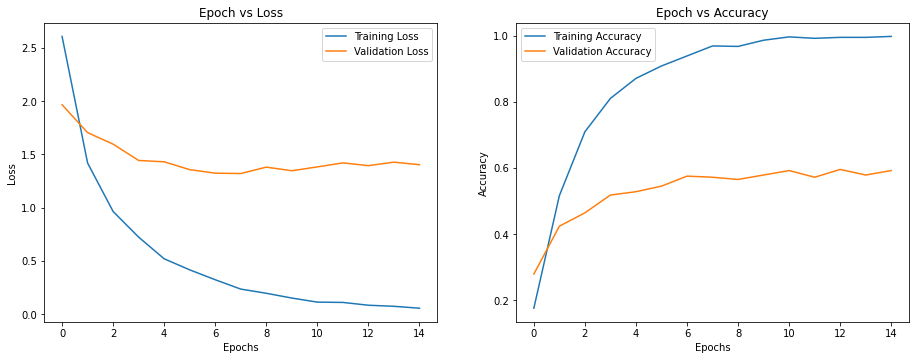

In [167]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [168]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features=num_features_before_fcnn, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.3059163059163059 
 The Validation acc 0.41414141414141414
The Train loss= 6.432003498077393 
 The Validation loss 4.082251388579607


The Train accuracy= 0.6204906204906205 
 The Validation acc 0.4377104377104377
The Train loss= 2.793229818344116 
 The Validation loss 5.65001414637685


The Train accuracy= 0.7431457431457431 
 The Validation acc 0.3164983164983165
The Train loss= 1.7380776405334473 
 The Validation loss 9.55380096868114


The Train accuracy= 0.862914862914863 
 The Validation acc 0.531986531986532
The Train loss= 0.7442392110824585 
 The Validation loss 4.15180707291552


The Train accuracy= 0.8903318903318903 
 The Validation acc 0.5791245791245792
The Train loss= 0.637437105178833 
 The Validation loss 4.119987203886635


The Train accuracy= 0.9668109668109668 
 The Validation acc 0.5824915824915825
The Train loss= 0.12087499350309372 
 The Validation loss 4.223834337862699


The Train accuracy= 0.987012987012987 
 The Validation acc 0.592592592

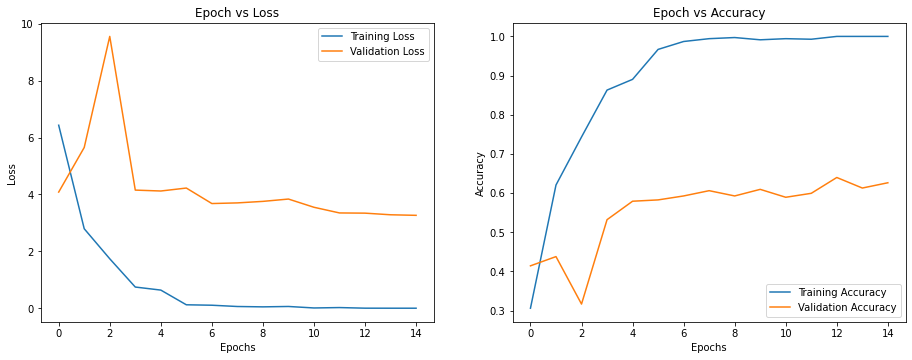

In [169]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# changing the data

In [170]:
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.6, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))
# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.2828282828282828 
 The Validation acc 0.2702020202020202
The Train loss= 2.6573312282562256 
 The Validation loss 2.066330475466592


The Train accuracy= 0.7188552188552189 
 The Validation acc 0.5126262626262627
The Train loss= 0.8984323740005493 
 The Validation loss 1.354594154017312


The Train accuracy= 0.9141414141414141 
 The Validation acc 0.5378787878787878
The Train loss= 0.3175916373729706 
 The Validation loss 1.490236989089421


The Train accuracy= 0.9444444444444444 
 The Validation acc 0.48737373737373735
The Train loss= 0.20032377541065216 
 The Validation loss 1.866211120571409


The Train accuracy= 0.9494949494949495 
 The Validation acc 0.44696969696969696
The Train loss= 0.17400801181793213 
 The Validation loss 2.0761954188346863


The Train accuracy= 0.9393939393939394 
 The Validation acc 0.46464646464646464
The Train loss= 0.1922064870595932 
 The Validation loss 2.2679078919546947


The Train accuracy= 0.9629629629629629 
 The Validation a

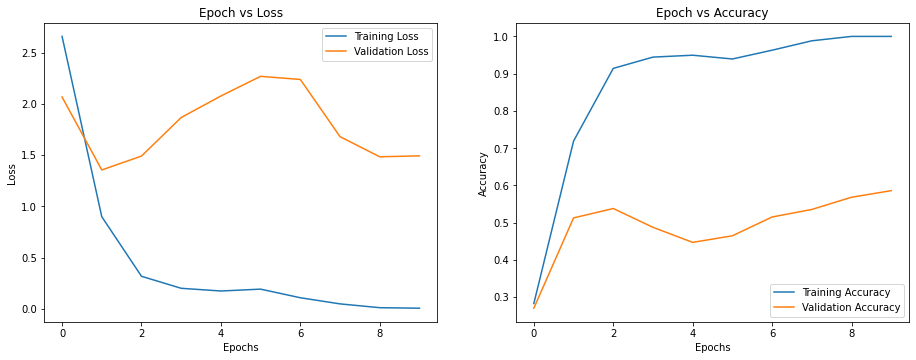

In [171]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [174]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),
        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=128),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.2222222222222222 
 The Validation acc 0.2601010101010101
The Train loss= 5.265918731689453 
 The Validation loss 2.218509699617113


The Train accuracy= 0.6111111111111112 
 The Validation acc 0.39646464646464646
The Train loss= 1.7040884494781494 
 The Validation loss 2.1505591443606784


The Train accuracy= 0.8265993265993266 
 The Validation acc 0.5303030303030303
The Train loss= 0.5801018476486206 
 The Validation loss 2.1367867248398915


The Train accuracy= 0.9208754208754208 
 The Validation acc 0.41919191919191917
The Train loss= 0.22755706310272217 
 The Validation loss 2.77618294102805


The Train accuracy= 0.9427609427609428 
 The Validation acc 0.4722222222222222
The Train loss= 0.17661352455615997 
 The Validation loss 2.640251874923706


The Train accuracy= 0.9713804713804713 
 The Validation acc 0.4722222222222222
The Train loss= 0.10936365276575089 
 The Validation loss 2.7060239570481435


The Train accuracy= 0.9949494949494949 
 The Validation ac

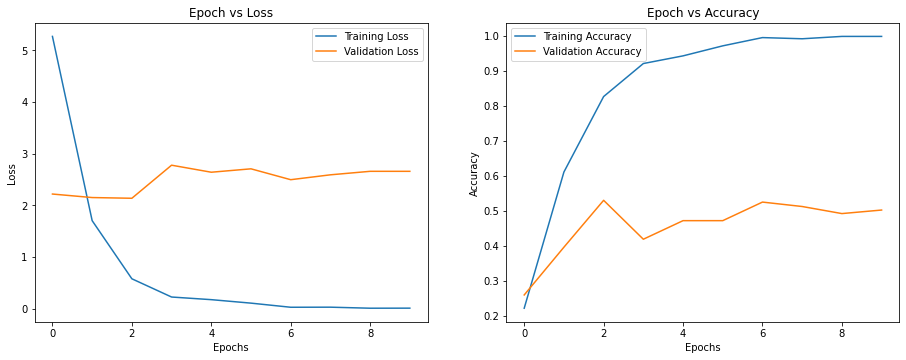

In [175]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [176]:

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),  
            )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=128),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.2356902356902357 
 The Validation acc 0.18686868686868688
The Train loss= 8.020255088806152 
 The Validation loss 7.219217436654227


The Train accuracy= 0.6616161616161617 
 The Validation acc 0.39646464646464646
The Train loss= 2.2340471744537354 
 The Validation loss 3.231755409921919


The Train accuracy= 0.8383838383838383 
 The Validation acc 0.4722222222222222
The Train loss= 0.6547011733055115 
 The Validation loss 2.4991475769451688


The Train accuracy= 0.9141414141414141 
 The Validation acc 0.40404040404040403
The Train loss= 0.2635304927825928 
 The Validation loss 3.9263518367494856


The Train accuracy= 0.9427609427609428 
 The Validation acc 0.5075757575757576
The Train loss= 0.2249981164932251 
 The Validation loss 3.9578437336853574


The Train accuracy= 0.9562289562289562 
 The Validation acc 0.4797979797979798
The Train loss= 0.19427838921546936 
 The Validation loss 4.31772129876273


The Train accuracy= 0.9831649831649831 
 The Validation acc

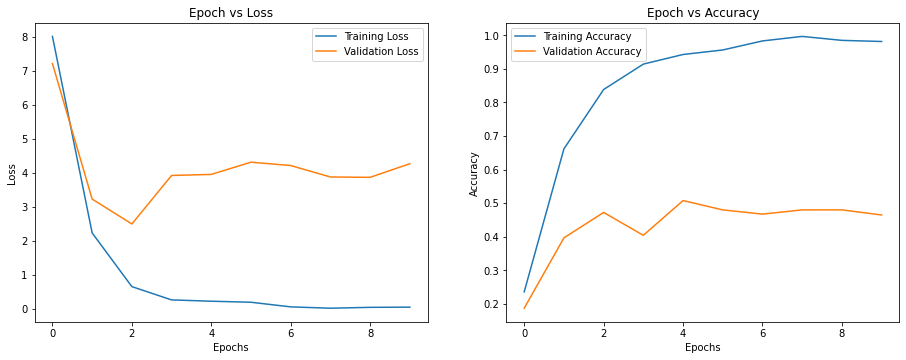

In [177]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# compining different features

In [178]:
first_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
sec_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_1.npy')
third_feat=np.load('/content/drive/MyDrive/NMA_DL_project/feature_2.npy')
forth_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_3.npy')

In [181]:
first_and_sec= np.concatenate( (first_feat , sec_feat), axis=1) 

In [182]:
first_and_sec.shape

(990, 129, 645)

In [191]:
first_and_sec= np.concatenate( (first_feat , sec_feat), axis=1).reshape(990,1,129,645)

x_train , x_test , y_train , y_test = train_test_split( first_and_sec , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.16017316017316016 
 The Validation acc 0.2356902356902357
The Train loss= 2.258679151535034 
 The Validation loss 2.193991780281067


The Train accuracy= 0.3448773448773449 
 The Validation acc 0.31986531986531985
The Train loss= 1.8326551914215088 
 The Validation loss 1.9207109570503236


The Train accuracy= 0.43434343434343436 
 The Validation acc 0.4175084175084175
The Train loss= 1.5997542142868042 
 The Validation loss 1.713357436656952


The Train accuracy= 0.5151515151515151 
 The Validation acc 0.44107744107744107
The Train loss= 1.3973708152770996 
 The Validation loss 1.571971881389618


The Train accuracy= 0.556998556998557 
 The Validation acc 0.4612794612794613
The Train loss= 1.2646548748016357 
 The Validation loss 1.4951324582099914


The Train accuracy= 0.6233766233766234 
 The Validation acc 0.4983164983164983
The Train loss= 1.128407597541809 
 The Validation loss 1.4366609573364257


The Train accuracy= 0.6551226551226551 
 The Validation acc 

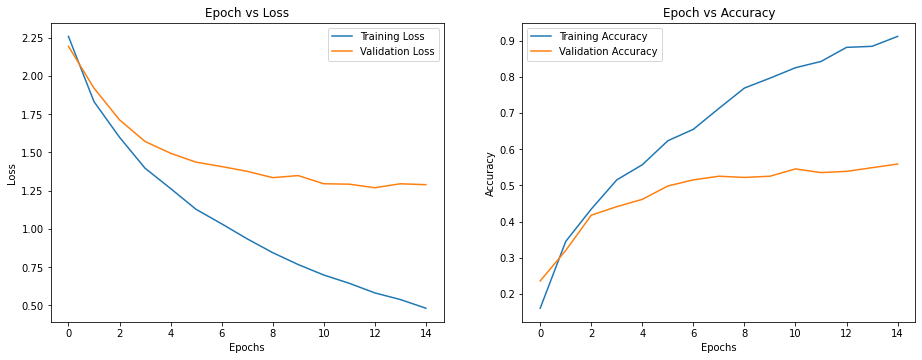

In [192]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The Train accuracy= 0.22943722943722944 
 The Validation acc 0.20202020202020202
The Train loss= 3.9232921600341797 
 The Validation loss 2.110575091838837


The Train accuracy= 0.4603174603174603 
 The Validation acc 0.39730639730639733
The Train loss= 1.5154303312301636 
 The Validation loss 1.6715455532073975


The Train accuracy= 0.5627705627705628 
 The Validation acc 0.4444444444444444
The Train loss= 1.1741706132888794 
 The Validation loss 1.4533982396125793


The Train accuracy= 0.7561327561327561 
 The Validation acc 0.5589225589225589
The Train loss= 0.7723743915557861 
 The Validation loss 1.321398949623108


The Train accuracy= 0.8556998556998557 
 The Validation acc 0.5286195286195287
The Train loss= 0.509721577167511 
 The Validation loss 1.5305700600147247


The Train accuracy= 0.9278499278499278 
 The Validation acc 0.5454545454545454
The Train loss= 0.31779128313064575 
 The Validation loss 1.3790028929710387


The Train accuracy= 0.976911976911977 
 The Validation ac

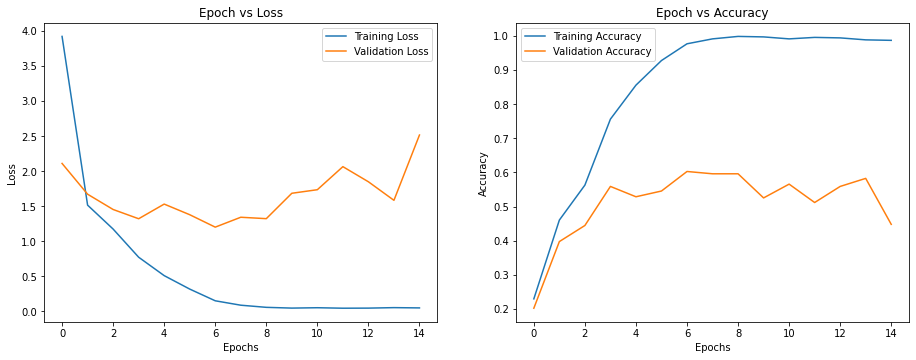

In [193]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The Train accuracy= 0.15873015873015872 
 The Validation acc 0.24915824915824916
The Train loss= 2.252499580383301 
 The Validation loss 2.2024261474609377


The Train accuracy= 0.2727272727272727 
 The Validation acc 0.2895622895622896
The Train loss= 1.9146593809127808 
 The Validation loss 1.9578392028808593


The Train accuracy= 0.40115440115440115 
 The Validation acc 0.37373737373737376
The Train loss= 1.6465924978256226 
 The Validation loss 1.7750326991081238


The Train accuracy= 0.4603174603174603 
 The Validation acc 0.4074074074074074
The Train loss= 1.4723032712936401 
 The Validation loss 1.6285359740257264


The Train accuracy= 0.5223665223665224 
 The Validation acc 0.43097643097643096
The Train loss= 1.3512895107269287 
 The Validation loss 1.5604061841964723


The Train accuracy= 0.5714285714285714 
 The Validation acc 0.4276094276094276
The Train loss= 1.2149848937988281 
 The Validation loss 1.5609410762786866


The Train accuracy= 0.6262626262626263 
 The Validatio

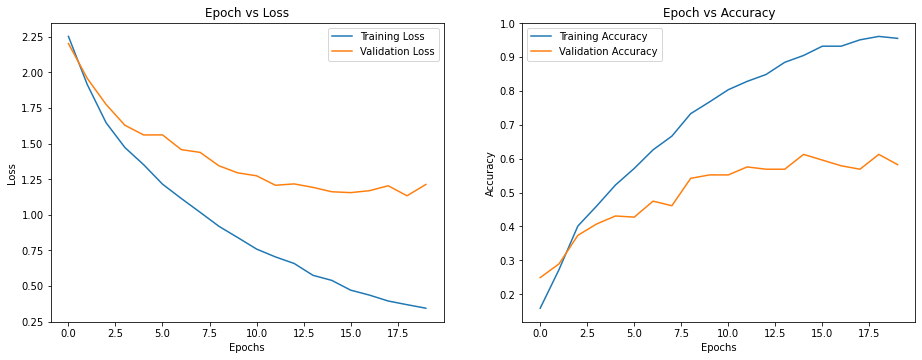

In [194]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 20 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# lets work with the same model but diff features

This SGD opt model

In [195]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out


## first and third features

In [196]:
first_and_third_feat= np.concatenate( (first_feat , third_feat), axis=1).reshape(990,1,129,645)

x_train , x_test , y_train , y_test = train_test_split( first_and_third_feat , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.15007215007215008 
 The Validation acc 0.19528619528619529
The Train loss= 2.2679076194763184 
 The Validation loss 2.1919286012649537


The Train accuracy= 0.30447330447330445 
 The Validation acc 0.23232323232323232
The Train loss= 1.9056951999664307 
 The Validation loss 2.141925883293152


The Train accuracy= 0.443001443001443 
 The Validation acc 0.3939393939393939
The Train loss= 1.6708263158798218 
 The Validation loss 1.6683412432670592


The Train accuracy= 0.46176046176046176 
 The Validation acc 0.5016835016835017
The Train loss= 1.4453705549240112 
 The Validation loss 1.3174286961555481


The Train accuracy= 0.5685425685425686 
 The Validation acc 0.5757575757575758
The Train loss= 1.1870611906051636 
 The Validation loss 1.2473484396934509


The Train accuracy= 0.6132756132756133 
 The Validation acc 0.49158249158249157
The Train loss= 1.065894365310669 
 The Validation loss 1.4409407377243042


The Train accuracy= 0.7258297258297258 
 The Validation

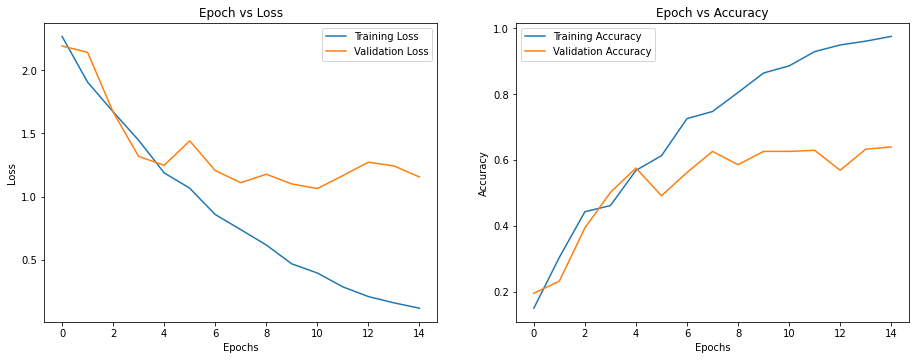

In [197]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## first and fourth features

In [200]:
forth_feat.shape

(990, 12, 645)

In [203]:
first_and_forth_feat= np.concatenate( (first_feat , forth_feat), axis=1).reshape( 990,1,140, 645)

x_train , x_test , y_train , y_test = train_test_split( first_and_forth_feat , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.15873015873015872 
 The Validation acc 0.3569023569023569
The Train loss= 2.224611282348633 
 The Validation loss 2.0976079225540163


The Train accuracy= 0.40115440115440115 
 The Validation acc 0.4208754208754209
The Train loss= 1.6908636093139648 
 The Validation loss 1.6109212636947632


The Train accuracy= 0.5050505050505051 
 The Validation acc 0.39730639730639733
The Train loss= 1.417298674583435 
 The Validation loss 1.7374178051948548


The Train accuracy= 0.6002886002886003 
 The Validation acc 0.5117845117845118
The Train loss= 1.194557785987854 
 The Validation loss 1.448136556148529


The Train accuracy= 0.6681096681096681 
 The Validation acc 0.5185185185185185
The Train loss= 0.9395972490310669 
 The Validation loss 1.37251096367836


The Train accuracy= 0.7734487734487735 
 The Validation acc 0.5791245791245792
The Train loss= 0.6639090180397034 
 The Validation loss 1.2317863166332246


The Train accuracy= 0.86002886002886 
 The Validation acc 0.6

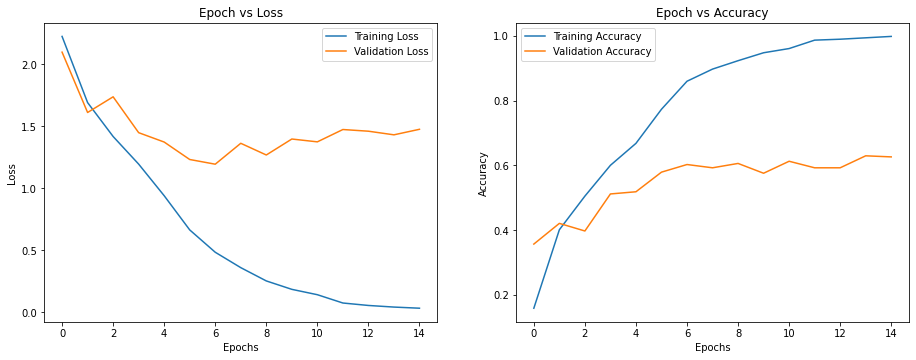

In [204]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## first, sec and third

In [207]:
three_features= np.concatenate( (first_feat , sec_feat  ,third_feat), axis=1).reshape( 990,1,130, 645)

x_train , x_test , y_train , y_test = train_test_split( three_features , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.15728715728715728 
 The Validation acc 0.22895622895622897
The Train loss= 2.3529722690582275 
 The Validation loss 2.2230239629745485


The Train accuracy= 0.30014430014430016 
 The Validation acc 0.2727272727272727
The Train loss= 2.142679214477539 
 The Validation loss 2.158768427371979


The Train accuracy= 0.3578643578643579 
 The Validation acc 0.2962962962962963
The Train loss= 1.8937968015670776 
 The Validation loss 2.0484707593917846


The Train accuracy= 0.4314574314574315 
 The Validation acc 0.3939393939393939
The Train loss= 1.5735039710998535 
 The Validation loss 1.756178879737854


The Train accuracy= 0.5324675324675324 
 The Validation acc 0.4377104377104377
The Train loss= 1.3153795003890991 
 The Validation loss 1.556534433364868


The Train accuracy= 0.5714285714285714 
 The Validation acc 0.4882154882154882
The Train loss= 1.1814545392990112 
 The Validation loss 1.4281901240348815


The Train accuracy= 0.6378066378066378 
 The Validation acc

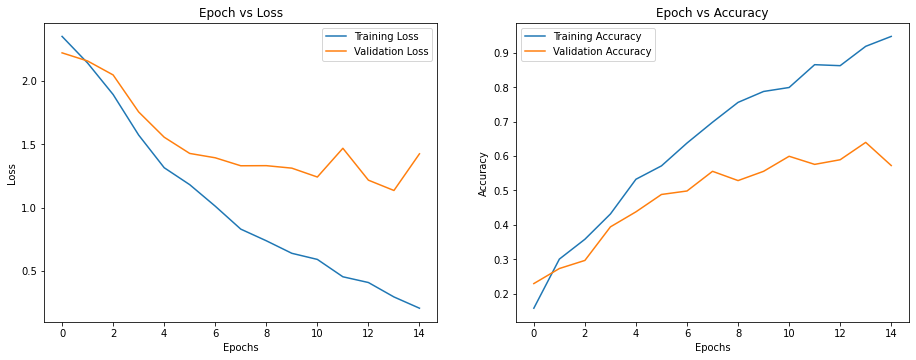

In [208]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

### three features with gausian

In [211]:
three_features= np.concatenate( (first_feat , sec_feat  ,third_feat), axis=1).reshape( 990,1,130, 645)

x_train , x_test , y_train , y_test = train_test_split( three_features , labels , train_size=0.7, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.17604617604617603 
 The Validation acc 0.16161616161616163
The Train loss= 2.3671257495880127 
 The Validation loss 2.207778584957123


The Train accuracy= 0.31457431457431456 
 The Validation acc 0.3164983164983165
The Train loss= 1.9362987279891968 
 The Validation loss 1.9709108471870422


The Train accuracy= 0.36363636363636365 
 The Validation acc 0.32996632996632996
The Train loss= 1.8208577632904053 
 The Validation loss 1.8296072006225585


The Train accuracy= 0.45454545454545453 
 The Validation acc 0.39057239057239057
The Train loss= 1.5227587223052979 
 The Validation loss 1.6042628645896913


The Train accuracy= 0.5367965367965368 
 The Validation acc 0.4781144781144781
The Train loss= 1.2324602603912354 
 The Validation loss 1.428585171699524


The Train accuracy= 0.5988455988455988 
 The Validation acc 0.47474747474747475
The Train loss= 1.0279271602630615 
 The Validation loss 1.3984360456466676


The Train accuracy= 0.6984126984126984 
 The Validat

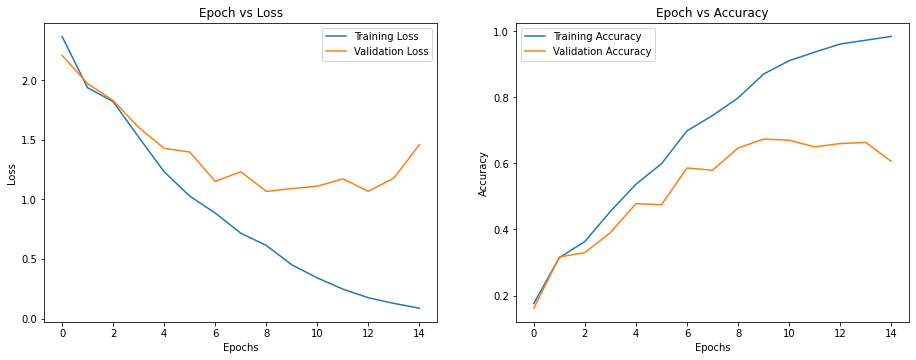

In [212]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## using all the features

In [214]:
all_features= np.concatenate( (first_feat , sec_feat  ,third_feat, forth_feat), axis=1).reshape( 990,1,142, 645)

x_train , x_test , y_train , y_test = train_test_split( all_features , labels , train_size=0.7, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.1111111111111111 
 The Validation acc 0.10101010101010101
The Train loss= 2.2880191802978516 
 The Validation loss 2.265250301361084


The Train accuracy= 0.2453102453102453 
 The Validation acc 0.19865319865319866
The Train loss= 2.0869131088256836 
 The Validation loss 2.1790125727653504


The Train accuracy= 0.31457431457431456 
 The Validation acc 0.31986531986531985
The Train loss= 1.899559736251831 
 The Validation loss 1.9166698217391969


The Train accuracy= 0.4025974025974026 
 The Validation acc 0.28619528619528617
The Train loss= 1.6444287300109863 
 The Validation loss 2.09240175485611


The Train accuracy= 0.4401154401154401 
 The Validation acc 0.43434343434343436
The Train loss= 1.4917733669281006 
 The Validation loss 1.6331398010253906


The Train accuracy= 0.48773448773448774 
 The Validation acc 0.45791245791245794
The Train loss= 1.381478190422058 
 The Validation loss 1.6276181221008301


The Train accuracy= 0.5382395382395382 
 The Validation

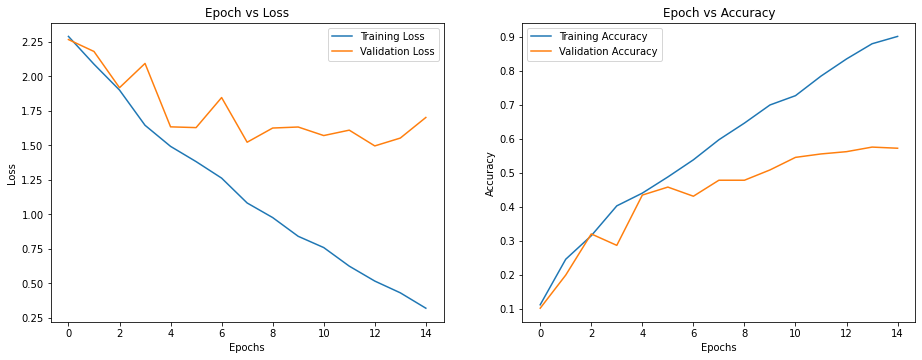

In [215]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)